<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

**Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's using topic modeling: 

- Load in the Amazon Review dataset
- Clean the dataset 
- Vectorize the dataset 
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import spacy

import pyLDAvis
import pyLDAvis.gensim 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline 

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
# pip install pandarallel

----
### Load the Amazon Review corpus 
This dataset is located in the Sprint 1 Module 1 directory. 

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [2]:
data_path = "../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [3]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer. 

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [4]:
# save to cleaned review articles to a feature named `clean_text`

# 1. Remove new line characters
df['clean_text'] = df['reviews.text'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace and lowercase text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.lower().split()))

<>:4: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<ipython-input-4-a21804818886>:4: DeprecationWarning: invalid escape sequence \s
  df['clean_text'] = df['reviews.text'].apply(lambda x: re.sub('\s+', ' ', x))
<ipython-input-4-a21804818886>:7: DeprecationWarning: invalid escape sequence \S
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))


In [5]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",i order of them and one of the item is bad qua...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",bulk is always the less expensive way to go fo...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",well they are not duracell but for the price i...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",seem to work as well as name brand batteries a...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",these batteries are very long lasting the pric...


In [6]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data. 

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use. 


In [7]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use msak to isolate all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [8]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,great case to keep everything in its place my ...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,after discarding and getting rid of broken cd ...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,a few dollars more but i am boycotting amazon


In [9]:
df_electronics.shape

(13995, 25)

In [10]:
df.shape

(28332, 25)

------
### Tokenize your documents 

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles. 



In [11]:
# identify how many processors your machine has - save the result to `n_processors`
import multiprocessing

n_processors = multiprocessing.cpu_count()
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# initialize just like we did in the guided project
# COLAB only has 2 processors, set nb_workers=2 and hope that it doesn't crash your notebook (otherwise don't use this tool)
#pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)

# YOUR CODE HERE


In [12]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_lg")

In [13]:
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
%%time
# create our tokens in the form of lemmas 
df_electronics['lemmas'] = df_electronics['clean_text'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

100%|██████████| 13995/13995 [01:59<00:00, 116.91it/s]

CPU times: user 1min 54s, sys: 3.53 s, total: 1min 58s
Wall time: 1min 59s



<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to. 

In [15]:
# Create lemma dictionary using Dictionary - save result to `id2word`

# Create Term Document Frequency list - save result to `corpus`
id2word = corpora.Dictionary(df_electronics['lemmas'])
corpus = [id2word.doc2bow(text) for text in df_electronics['lemmas']]
len(id2word.keys())

5480

## Gridsearch the number of topics 

Just as we did in the guided project, we're going to run a for loop over a range of possible number of topics and then plot the coherence values to determine which number of topics leads to the most sensible grouping of documents. 

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=22, step=2)

CPU times: user 2min 41s, sys: 26.6 s, total: 3min 8s
Wall time: 5min 44s


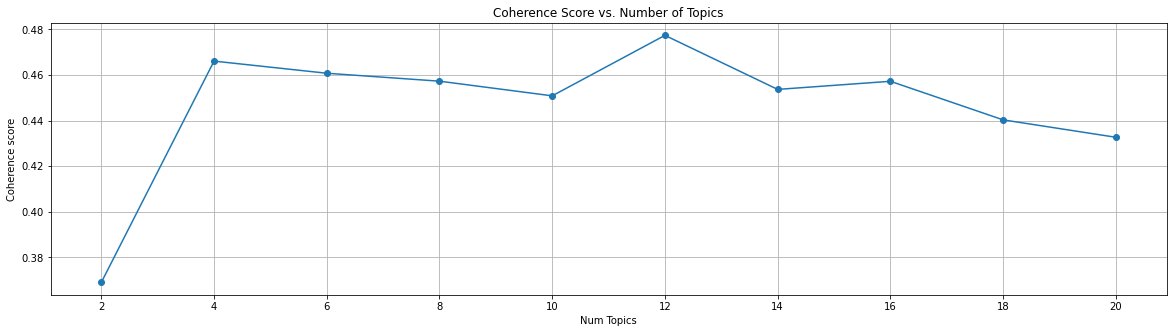

In [18]:
start=2; limit=22;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [19]:
coherence_values

[0.3690334512958807,
 0.4661293202893275,
 0.46080914797160505,
 0.45732580757265995,
 0.45089312594879416,
 0.47742815602683275,
 0.45371870617824916,
 0.45727751550732304,
 0.4403541378334058,
 0.4327184175605533]

In [21]:
type(coherence_values)

list

In [20]:
model_list

In [24]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_cohereance_val_index = np.argmax(coherence_values)
# use `max_cohereance_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_trained_model = model_list[max_cohereance_val_index]
# YOUR CODE HERE
lda_trained_model

## Use pyLDAvis to visual your topics 

Take a look at the topic bubbles and bar char for the terms on the right hand side.  

- Describe the topic bubbles. 
- Do they overlap or not? 
- What does it mean when they overlap? 
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [28]:
# plot your topics here
# from pprint import pprint
# pprint(lda_trained_model.print_topics())

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.099917 -0.079149       1        1  16.230216
11    -0.073790 -0.156482       2        1  11.426157
7     -0.088680  0.128300       3        1   9.582124
9     -0.105566  0.032265       4        1   8.761215
2      0.059358 -0.187924       5        1   8.496780
6      0.014010 -0.028155       6        1   8.157065
5      0.045423  0.144683       7        1   7.243055
0     -0.213309  0.139367       8        1   6.633268
3     -0.123000 -0.150735       9        1   6.362592
4      0.141255 -0.039513      10        1   6.222951
1      0.260142  0.130488      11        1   5.549648
8     -0.015761  0.066856      12        1   5.334929, topic_info=         Term         Freq        Total Category  logprob  loglift
126         t  2392.000000  2392.000000  Default  30.0000  30.0000
1297      kid  2152.000000  2152.000000  Default  29.0000  29.0000
852      read  1756.000000  1756.000000  Default  28.0000  28.0000
6        love  4370.000000  4370.000000  Default  27.0000  27.0000
430      book  1633.000000  1633.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
246       use    93.807481  3375.190457  Topic12  -4.7159  -0.6521
283   quality    68.812456   527.037828  Topic12  -5.0258   0.8950
28       like    77.294938  1757.153617  Topic12  -4.9095  -0.1929
36       play    74.028823  1359.691969  Topic12  -4.9527   0.0203
576   feature    59.419964   671.455685  Topic12  -5.1725   0.5061

[843 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1097      1  0.865949  absolutely
1097      3  0.020375  absolutely
1097      5  0.025469  absolutely
1097      6  0.035657  absolutely
1097      8  0.040751  absolutely
...     ...       ...         ...
1307      1  0.994078       young
1457      1  0.045332     youtube
1457      7  0.945500     youtube
1435      1  0.981932          yr
1435     11  0.011831          yr

[2053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 8, 10, 3, 7, 6, 1, 4, 5, 2, 9])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [44]:
# create a dictionary 
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`

# YOUR CODE HERE
vis_topic_name_dict = {
    1: "love",
    2: "great",
    3: "kindle",
    4: "tablet",
    5: "read",
    6: "use",
    7: "app",
    8: "t",
    9: "product",
    10: "kid",
    11: "kid",
    12: "speaker"
}

In [46]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids accoridng to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
#     print(model_vis_tool_topic_id_lookup)
#     print(model_vis_tool_topic_id_lookup[10])
#     print(model_vis_tool_topic_id_lookup.items())
    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
#     print(topic_id_lookup)
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [47]:
# YOUR CODE HERE
get_topic_id_lookup_dict(vis, vis_topic_name_dict)

{10: 'love',
 11: 'great',
 7: 'kindle',
 9: 'tablet',
 2: 'read',
 6: 'use',
 5: 'app',
 0: 't',
 3: 'product',
 4: 'kid',
 1: 'kid',
 8: 'speaker'}

## Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [48]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [49]:

# use get_topic_ids_for_docs get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_trained_model, corpus)
doc_topic_ids
# create a new feature in df_electronics called topic_id using `doc_topic_ids`

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`

# YOUR CODE HERE


[10,
 7,
 0,
 7,
 7,
 5,
 9,
 2,
 3,
 9,
 9,
 9,
 6,
 7,
 7,
 7,
 7,
 0,
 0,
 0,
 8,
 7,
 7,
 7,
 7,
 5,
 0,
 2,
 3,
 3,
 3,
 7,
 10,
 4,
 7,
 8,
 3,
 1,
 7,
 1,
 7,
 3,
 7,
 3,
 7,
 7,
 4,
 3,
 7,
 1,
 8,
 7,
 5,
 5,
 5,
 7,
 7,
 7,
 10,
 11,
 7,
 11,
 8,
 9,
 4,
 7,
 9,
 8,
 0,
 8,
 4,
 11,
 11,
 4,
 4,
 6,
 7,
 11,
 7,
 1,
 7,
 1,
 1,
 7,
 0,
 7,
 11,
 7,
 3,
 3,
 7,
 7,
 7,
 5,
 7,
 6,
 7,
 11,
 3,
 7,
 1,
 6,
 7,
 6,
 3,
 7,
 7,
 4,
 10,
 6,
 0,
 11,
 8,
 0,
 7,
 11,
 0,
 7,
 7,
 7,
 11,
 11,
 3,
 0,
 6,
 0,
 0,
 7,
 7,
 6,
 3,
 7,
 3,
 11,
 7,
 3,
 11,
 7,
 8,
 0,
 0,
 8,
 8,
 8,
 6,
 6,
 8,
 6,
 8,
 0,
 6,
 8,
 2,
 0,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 11,
 2,
 8,
 9,
 8,
 8,
 8,
 8,
 4,
 8,
 3,
 10,
 8,
 8,
 8,
 3,
 4,
 10,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 11,
 8,
 11,
 8,
 8,
 11,
 0,
 10,
 7,
 8,
 8,
 8,
 6,
 8,
 8,
 8,
 8,
 8,
 0,
 3,
 1,
 10,
 8,
 8,
 8,
 8,
 8,
 10,
 8,
 8,
 8,
 8,
 0,
 10,
 10,
 10,
 11,
 8,
 1,
 6,
 10,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 6,
 8,
 8,
 

In [53]:
df_electronics['topic_id'] = doc_topic_ids

<ipython-input-53-ec98c8586e09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electronics['topic_id'] = doc_topic_ids


In [58]:
df_electronics['new_topic_name'] = df_electronics['topic_id'].map(vis_topic_name_dict)   

<ipython-input-58-445afce1319a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electronics['new_topic_name'] = df_electronics['topic_id'].map(vis_topic_name_dict)


In [59]:
df_electronics["new_topic_name"].head()

8343    kid
8344    app
8345    NaN
8346    app
8347    app
Name: new_topic_name, dtype: object

In [51]:
df_electronics.shape

(13995, 26)

In [52]:
len(doc_topic_ids)

13995

## Congratulations! You have created new topic names for your documents. 

In [60]:
cols = ["reviews.text", "new_topic_name"]
df_electronics[cols].head()

,reviews.text,new_topic_name
8343,Great case to keep everything in its place! My...,kid
8344,After discarding and getting rid of broken cd ...,app
8345,"A few dollars more, but I am boycotting amazon",NaN
8346,My initial impression of this was very good. T...,app
8347,Pros: Standard Echo. Cons: Older generation Ec...,app


-----
# Stretch Goals

- Treat `new_topic_name` as a Y vector and train a supervised learning model to predict the topic of each document